In [21]:
import csv

# Define the path to the text file
log_txt_file = "0909-ori-20v0.txt"

try:
    # Read the log data from the text file
    with open(log_txt_file, "r") as file:
        lines = file.readlines()

    # Parse the lines and prepare the CSV data
    csv_data = [["Time", "EventType", "x", "y", "z", "r", "n"]]  # CSV headers

    for line in lines:
        line = line.strip()
        if line and line[0].isdigit():  # Only process lines with events
            parts = line.split("\t")
            # if parts[1] == "p":
            csv_data.append(parts + [""] * (6 - len(parts)))  # Ensure 6 columns in the CSV
            # else:
            #     csv_data.append(parts + [""] * (3 - len(parts)))

    # Write the parsed data to a CSV file
    csv_filename = "0909-ori-20v0.csv"
    with open(csv_filename, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerows(csv_data)

    print(f"CSV file saved as {csv_filename}")

except FileNotFoundError:
    print(f"Error: The file {log_txt_file} was not found.")
except Exception as e:
    print(f"An error occurred: {e}")


CSV file saved as 0925-fixed-20v0.csv


In [27]:
import pandas as pd

# Load the CSV file into a dataframe
df = pd.read_csv('0909-ori-20v0.csv', sep=',', engine='python', on_bad_lines='skip')

# Count the occurrences of 'f', 'h', and 'n'
f_count = (df['EventType'] == 'f').sum()
h_count = (df['EventType'] == 'h').sum()
n_count = (df['EventType'] == 'n').sum()

# Calculate the ratios
f_ratio = f_count / n_count if n_count != 0 else 0
h_ratio = h_count / n_count if n_count != 0 else 0

# Display the results
print(f"Number of 'f' events: {f_count}")
print(f"Number of 'h' events: {h_count}")
print(f"Ratio of 'f' to 'n': {f_ratio}")
print(f"Ratio of 'h' to 'n': {h_ratio}")

Number of 'f' events: 528
Number of 'h' events: 23548
Ratio of 'f' to 'n': 0.021929642397308633
Ratio of 'h' to 'n': 0.9780288241890601


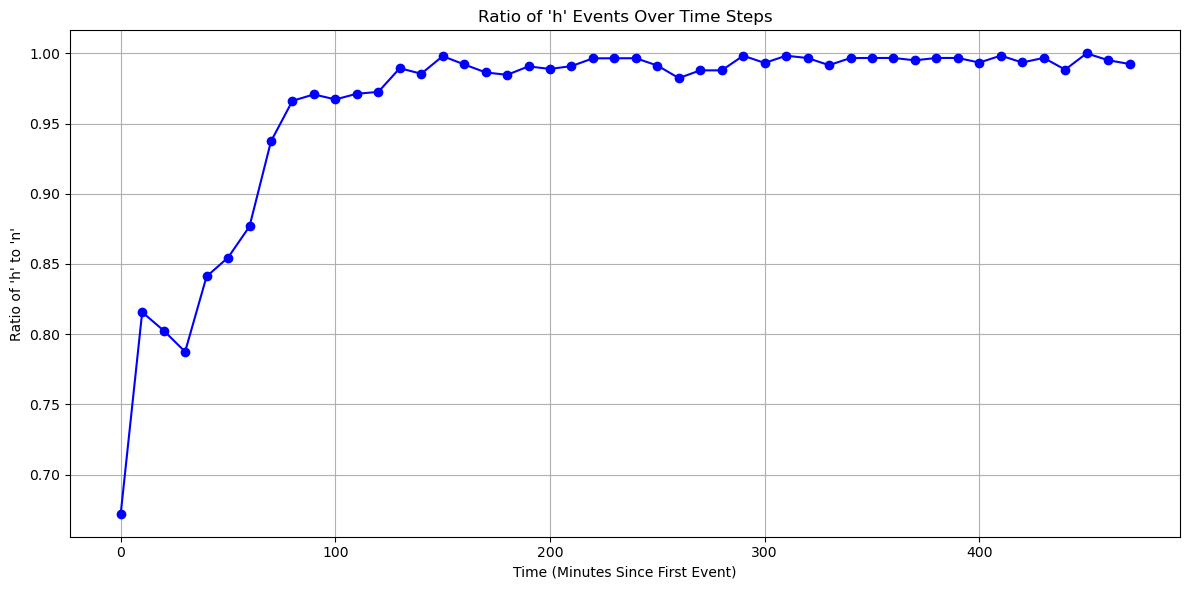

In [34]:
# Convert 'Time' column to datetime if it's not already
df['Time'] = pd.to_datetime(df['Time'])

# Find the first event time
first_time = df['Time'].min()

# Calculate time difference from the first event (in seconds or minutes, depending on your preference)
df['TimeStep'] = (df['Time'] - first_time).dt.total_seconds() / 60  # Convert to minutes

# Define time intervals (e.g., every 10 minutes)
interval = 10
df['TimeInterval'] = (df['TimeStep'] // interval) * interval

# Group by time interval
time_grouped = df.groupby('TimeInterval')

# Initialize lists for storing results
intervals = []
h_ratios = []

# Calculate the ratio of 'h' events for each time interval
for interval, group in time_grouped:
    f_count = (group['EventType'] == 'f').sum()
    h_count = (group['EventType'] == 'h').sum()
    n_count = (group['EventType'] == 'n').sum()
    
    # Avoid division by zero
    ratio_h = h_count / n_count if n_count != 0 else 0
    
    intervals.append(interval)
    h_ratios.append(ratio_h)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(intervals, h_ratios, marker='o', linestyle='-', color='b')
plt.xlabel('Time (Minutes Since First Event)')
plt.ylabel('Ratio of \'h\' to \'n\'')
plt.title('Ratio of \'h\' Events Over Time Steps')
plt.grid(True)
plt.tight_layout()
plt.show()

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

def calculate_h_ratio(file_path):

# Load the CSV file into a dataframe
# df = pd.read_csv('0909-ori-20v0.csv', sep=',', engine='python', on_bad_lines='skip')
    df = pd.read_csv(file_path, sep=',', engine='python', on_bad_lines='skip')
    df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S.%f')

# Create a 'Trial' column, incrementing a counter every time an 'n' event occurs
    df['Trial'] = (df['EventType'] == 'n').cumsum()
    df['Group'] = (df['Trial'] - 1) // 250
    trial_grouped = df.groupby('Group')

    # Initialize lists to store trial numbers and h-ratios
    trials = []
    h_ratios = []

    # Calculate the ratio of 'h' events for each trial
    for trial, group in trial_grouped:
        # total_events = len(group)
        h_count = (group['EventType'] == 'h').sum()
        n_count = (group['EventType'] == 'n').sum()
        
        # Calculate the ratio of 'h' to total events
        h_ratio = h_count / n_count if n_count != 0 else 0

        # if h_count == 0:
        #     print(f"Trial {trial}: {h_count} 'h' events out of {total_events} total events")
        
        trials.append(trial)
        h_ratios.append(h_ratio)
    
    return trials, h_ratios
    
    # Plotting the ratio of 'h' events per trial
   

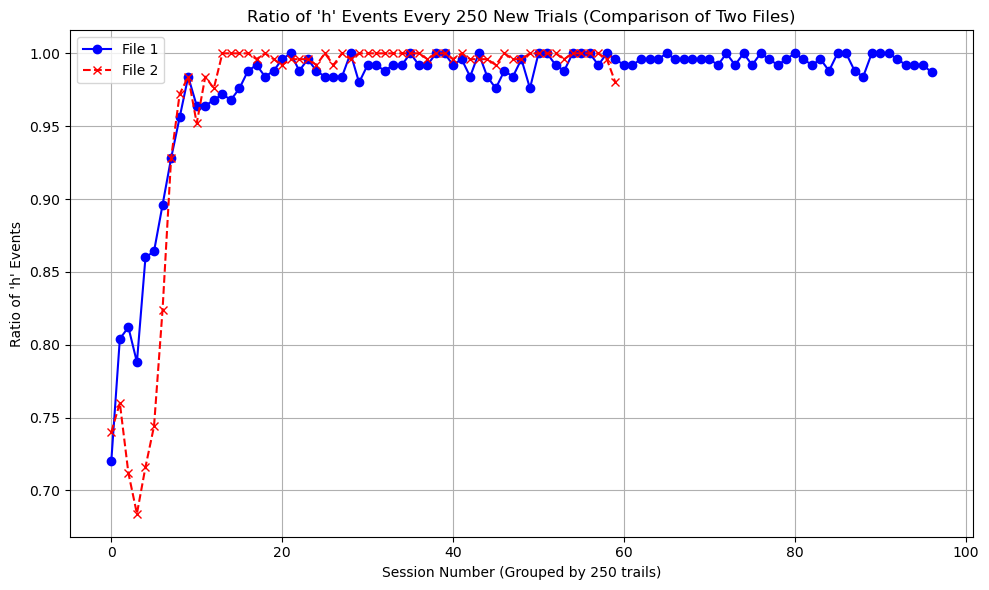

In [39]:
# Calculate the ratios for the two files
groups_file1, h_ratios_file1 = calculate_h_ratio('0909-ori-20v0.csv')
groups_file2, h_ratios_file2 = calculate_h_ratio('0925-fixed-20v0.csv')

# Plotting
plt.figure(figsize=(10, 6))

# Plot ratios from the first file
plt.plot(groups_file1, h_ratios_file1, label='File 1', marker='o', linestyle='-', color='b')

# Plot ratios from the second file
plt.plot(groups_file2, h_ratios_file2, label='File 2', marker='x', linestyle='--', color='r')

# Labeling the plot
plt.xlabel('Session Number (Grouped by 250 trails)')
plt.ylabel('Ratio of \'h\' Events')
plt.title('Ratio of \'h\' Events Every 250 New Trials (Comparison of Two Files)')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()